# **Childproofing - Heavy Objects - Boston**
## Notebook V 1.2

## Description
The notebook is designed to walk you through the project that was assigned to us - which consists of detecting heavy objects that might potentially endenger children (infants, toddlers, pre-schoolers and school-aged-children). 
For our approach, we chose to opt for a multi-label classifier, to correctly identify those objects.

A multi-label classifier is, in our sense, the best method to deal with real-estate, because images may contain a variety of objects, either safe or not safe, the Neural Network needs to correctly distinguish between every object present in a photograph, and only alerts us if a dangerous object is detected.

For example, if an image contains a safe furniture and an unsafe TV, the CNN needs to understand what is dangerous and what is safe, hence, a multi-labeling approach. Illustrations will be displayed, to have furhter context about the model.

The Fastai Library offers a good environement to work on multi-labeling, but in order for it to fully capture the images, the dataset had to be adjusted in a certain way. In contrast to binary or multi-classification, Fastai requires the images not to be in separate folders, but rather in one single folder, labeled via a CSV File. 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fellowship/platform-demos4/blob/master/Childproofing%20from%20Heavyobjects/multilabel_heavyobjects.ipynb)

In [0]:
from fastai.vision import *
from google.colab import drive
import seaborn as sns
from matplotlib.pyplot import figure

Starting by importing the relevent libraries:

1.   fastai.vision for modeling
2.   google.colab for data accessing 
3.   matplotlib and seaborn for data visualization





# **1. EDA**

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls '/content/drive/My Drive/'

 all/                filename.csv   finale/             T1/        THIS/
'Colab Notebooks'/   Final/         Multi-Label-Test/   Test-AI/


In [0]:
path = Path('/content/drive/My Drive/T1/Files')

In [0]:
ls '/content/drive/My Drive/T1'

Files/  finalenames.csv


The data is contained in the T1 folder - labels are in 'finalnames.csv' and the images are in sub folder 'Files'

In [0]:
df = pd.read_csv( '/content/drive/My Drive/T1/finalenames.csv') ; df.tail()

,image_name,tags
1441,ut uf (95).jpg,ut uf
1442,ut uf (96).jpg,ut uf
1443,ut uf (97).jpg,ut uf
1444,ut uf (98).jpg,ut uf
1445,ut uf (99).jpg,ut uf


Using Pandas DataFrame to display the data, which consists of labels for our images...

In [0]:
df.tags.value_counts()

safe       640
uk         308
uf         219
ut         159
ut uf      114
ut safe      6
Name: tags, dtype: int64

Here we display the number of images per class...

In [0]:
len(df.tags)

1446

And the total length of the entire dataset.

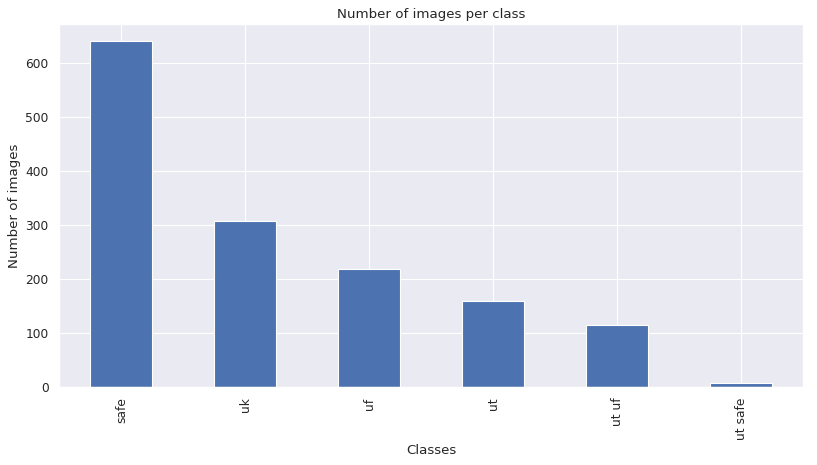

In [0]:
sns.set()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Number of images per class')
plt.ylabel('Number of images')
plt.xlabel('Classes')
df.tags.value_counts().plot.bar()

Using Matplotlib and Seaborn, the above Histogram shows how many unique images we have per class.

In [0]:
one_label = len(df[df.tags == 'safe']) + len(df[df.tags == 'uk']) + len(df[df.tags == 'ut']) + len(df[df.tags == 'uf'])
two_labels = len(df[df.tags == 'ut uf']) + len(df[df.tags == 'ut safe'])

<BarContainer object of 2 artists>

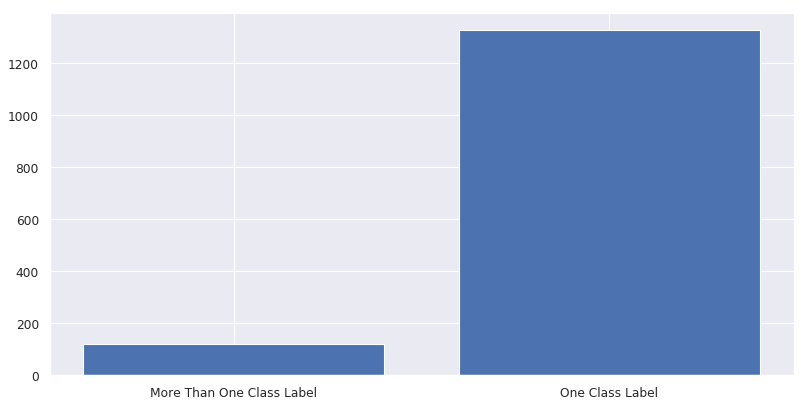

In [0]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(['More Than One Class Label', 'One Class Label'], [two_labels, one_label])

And here, the histogram displays how many images belong to more than one class at the same time (ex: Safe Furniture and Unsafe TV)

In [0]:
df.isna().sum()

image_name    0
tags          0
dtype: int64

Making sure there are no null values.

# 2. Modeling

Here, we created a data object using the ImageList class, which can take any kind of DataLoader class and Dataset class, provided a path to the dataset, the name of the .csv file (since we utilized the method .from_csv), defined the path to the images, and how the different categories can be separated (label_delim = '   '). We also included data augmentation (get_transforms). 

The data object created will then be incorporated in the model.



In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, '/content/drive/My Drive/T1/finalenames.csv', folder='')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
data.classes

['safe', 'uf', 'uk', 'ut']

We have four separate classes: 



*   Unsafe Furniture
*   Unsafe Kitchen
*   Unsafe TVs
*   Negative Class: Safe

We also have a combination of two classes:


1.   Unsafe TVs/Unsafe Furniture
2.   Unsafe TVs/Negative Class







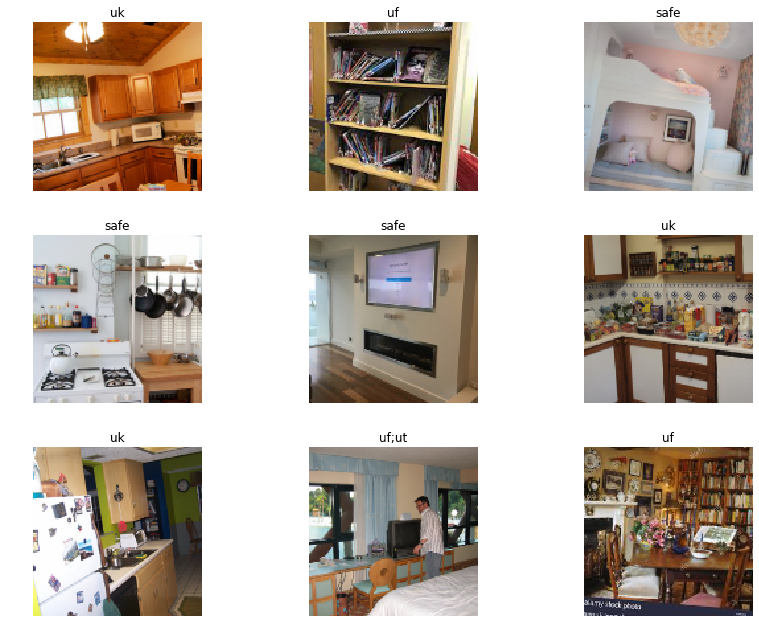

In [0]:
data.show_batch(rows=3, figsize=(12,9))

To have a sense about our data, above we displayed 9 different images. Some of them belong to unique classes, and some of them belong to two classes (separated by ';')

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(data, models.resnet34, metrics=[acc_02])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 17808429.46it/s]


Using Resnet34, we create a CNN with 'accuracy_thresh' of 0.2 as a metric of evaluation. The main idea behind this is to make the model know that if an image has at least 20% chance of being labled in a category X, it needs to be included in the model prediction. In contrast to other types of classification, where the sum of all the predictions add up to 100%, multi-labeling does not use the same approach. Technically, we use the sum of binary cross entropies of each labels.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


lr_find() method to find the optimal learning rate for the dataset.

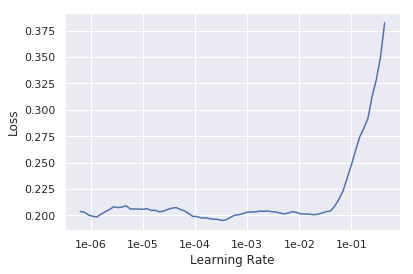

In [0]:
learn.recorder.plot()

The optimal learning rate here is somewhere between 0.01 and 0.001

In [0]:
learn.fit_one_cycle(8, (1e-02/2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.754931,0.609584,0.400519,01:10
1,0.625137,0.456371,0.622837,00:33
2,0.514426,0.408241,0.782872,00:33
3,0.438096,0.413104,0.778547,00:32
4,0.378993,0.375500,0.801038,00:32
5,0.331430,0.368028,0.804498,00:33
6,0.291584,0.373385,0.809689,00:33
7,0.262528,0.373443,0.810554,00:34


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

79 misclassified samples over 289 samples in the validation set.


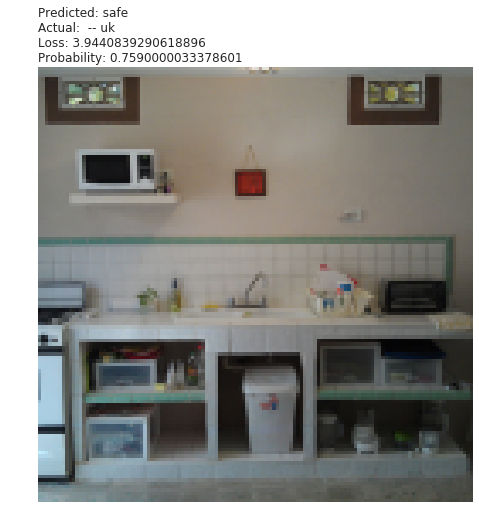

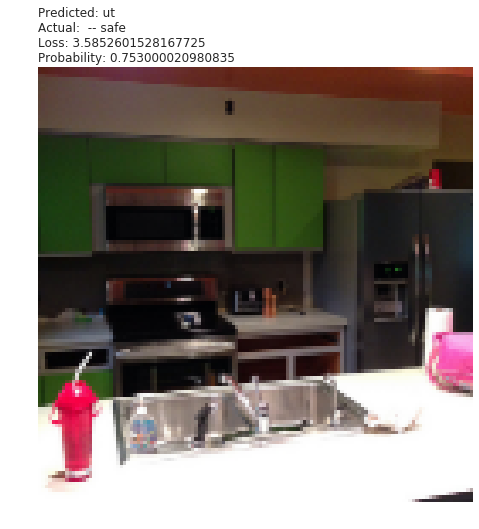

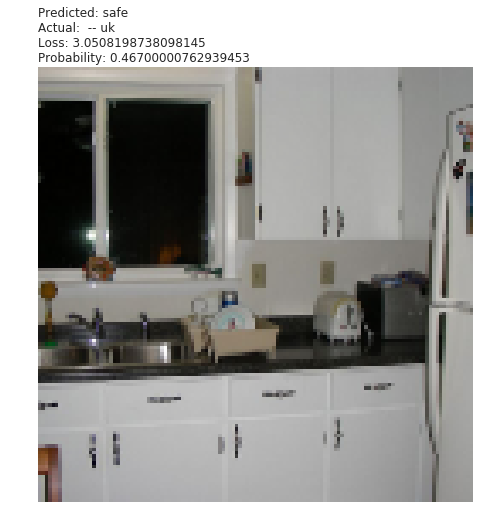

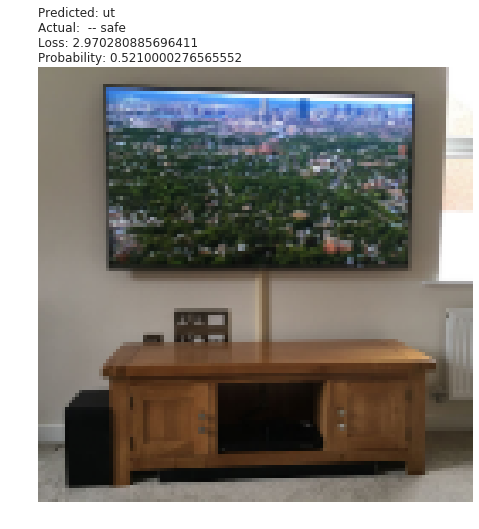

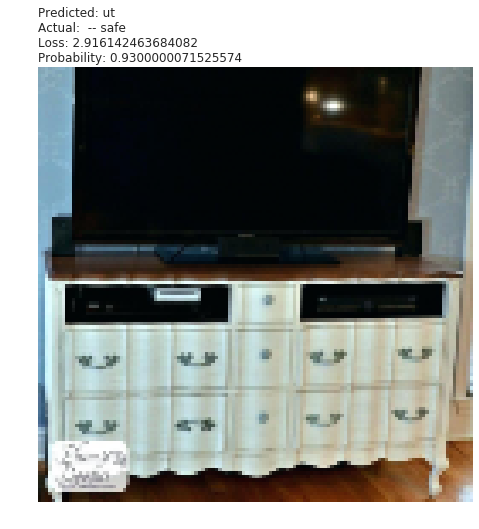

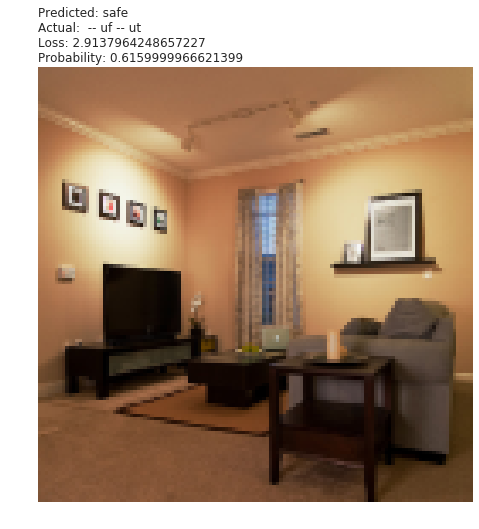

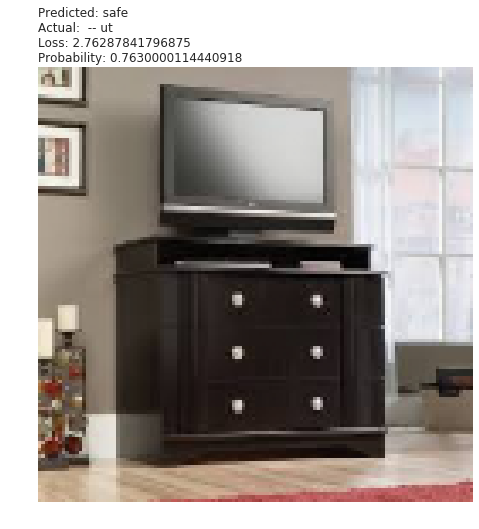

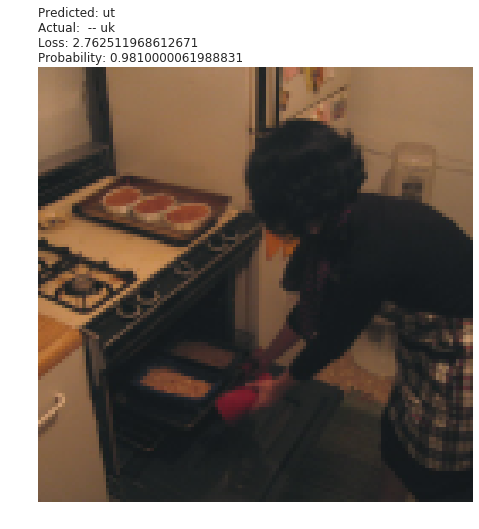

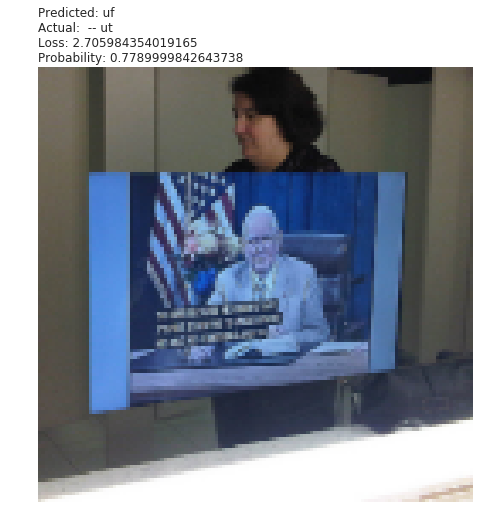

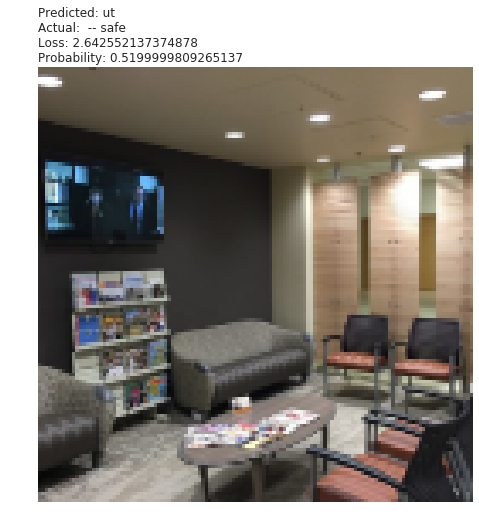

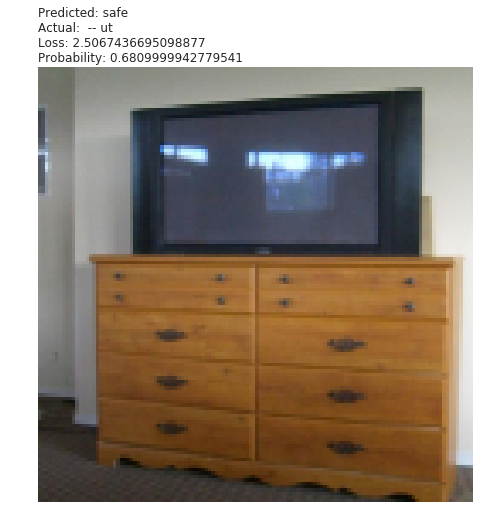

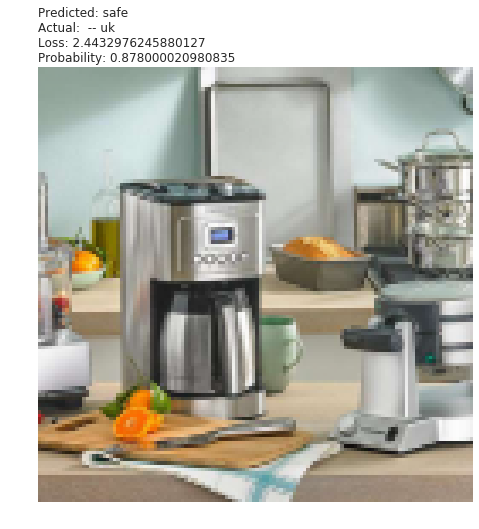

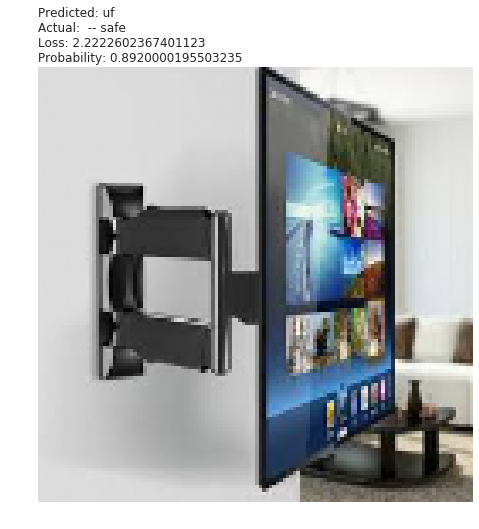

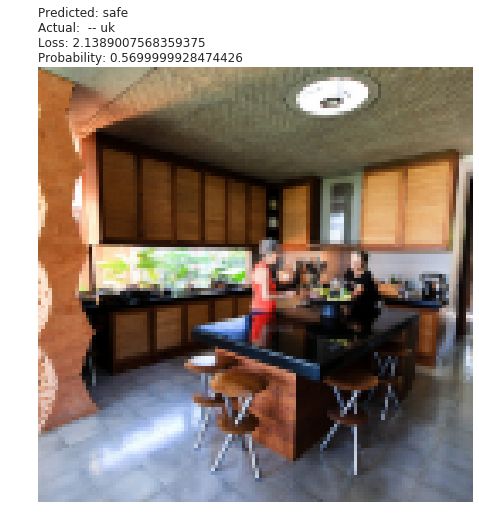

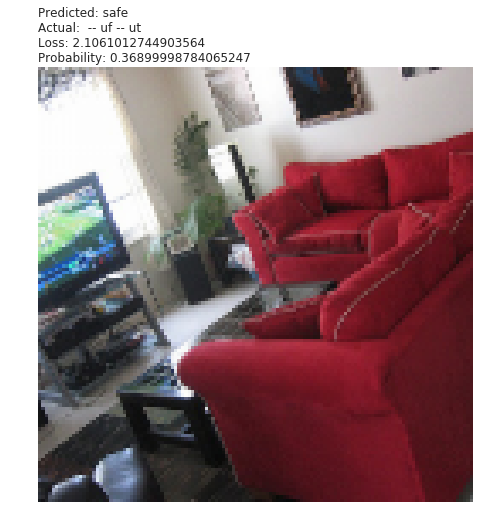

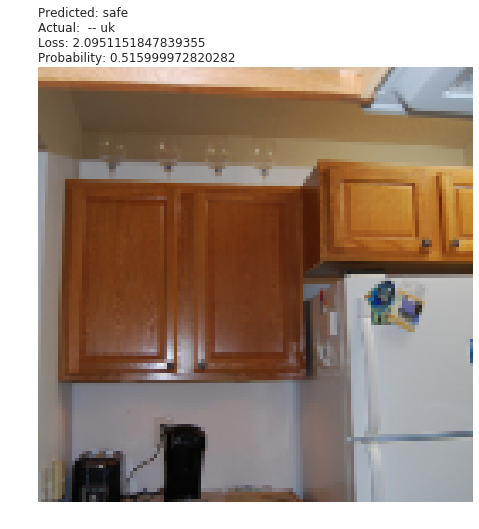

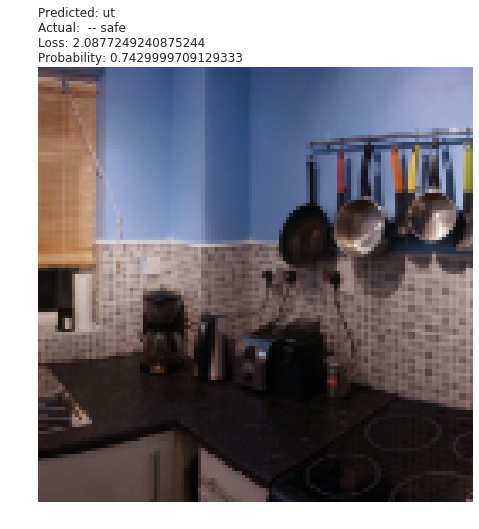

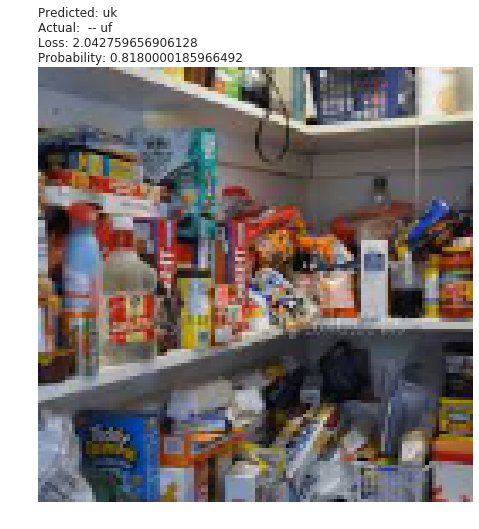

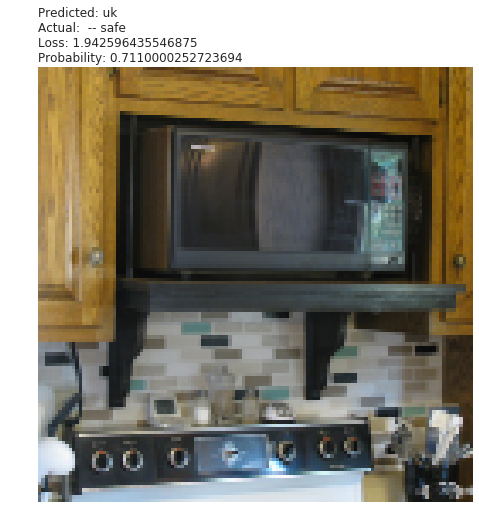

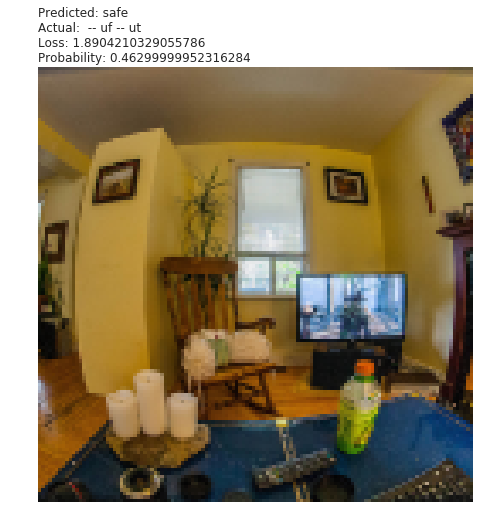

In [0]:
interp.plot_multi_top_losses(samples=20)

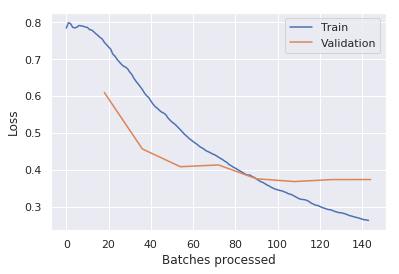

In [0]:
learn.recorder.plot_losses()

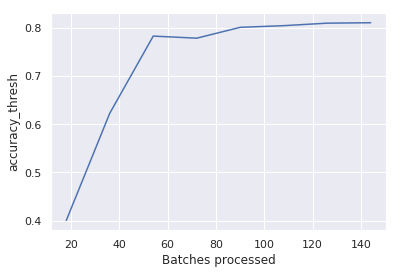

In [0]:
learn.recorder.plot_metrics()

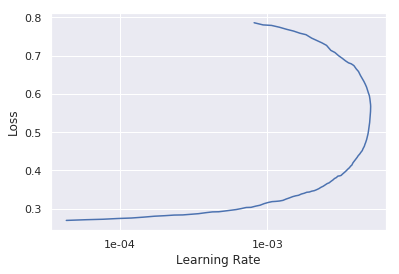

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, (1e-02/2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.201356,0.373500,0.810554,00:35


In [0]:
learn.save('/content/drive/My Drive/T1/st-1-34')